## Table of Contents

* [Imports](#Imports)
* [Feature Engineering](#Feature-Engineering)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Sentiment Analysis](#Sentiment-Analysis)
* [TF-IDF](#TF-IDF)
* [Pre-Processing](#Pre-Processing)
* [Topic Modeling](#Topic-Modeling)

### Imports

In [1]:
# ! pip install pyLDAvis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import scipy
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from gensim import matutils
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

#### Read In the Data

In [3]:
listing = pd.read_csv('./data/Asheville_Listings_Clean')
review = pd.read_csv('./data/Asheville_Reviews_Clean')

#### Allowing up to 100 columns to be previewed

In [4]:
pd.set_option("display.max_columns", 100)

# Feature Engineering

In [5]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms_text,bedrooms,amenities,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",2010-12-16,I am a long time resident of Asheville and am ...,within a few hours,0.25,2,28801,35.60670,-82.55563,Entire apartment,2,1 bath,1.0,"[""Free parking on premises"", ""Essentials"", ""Co...",$82.00,30,365,89,2011-09-21,2019-11-30,90.0,9.0,9.0,10.0,10.0,10.0,9.0,f,0.78
1,155305,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",2011-06-26,We operate two traveler's hostels located in H...,within an hour,1.00,7,28806,35.57864,-82.59578,Entire guesthouse,2,1 bath,1.0,"[""Oven"", ""Hair dryer"", ""Free parking on premis...",$90.00,1,365,289,2011-07-31,2021-02-13,91.0,10.0,9.0,10.0,10.0,10.0,9.0,t,2.48
2,156805,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",2011-06-26,We operate two traveler's hostels located in H...,within an hour,1.00,7,28806,35.57864,-82.59578,Private room in house,2,2.5 shared baths,1.0,"[""Coffee maker"", ""Fire extinguisher"", ""Lock on...",$66.00,1,365,67,2011-09-20,2020-01-01,90.0,10.0,9.0,10.0,9.0,10.0,9.0,t,0.58


Binarize the columns in order to use data for EDA.

In [6]:
listing['instant_bookable'] = listing['instant_bookable'].map({'f': 0, 't': 1})

Unpacking the list in the 'amenities' column and create dummy columns for each item in the amenities list.

In [7]:
listing['amenities'] = listing['amenities'].map(lambda x: ast.literal_eval(x))

listing = pd.concat([listing, pd.get_dummies(listing['amenities'].apply(pd.Series).stack()).sum(level=0)], axis=1)

In [8]:
listing.drop(columns = ['amenities'], inplace = True)

Creating new columns that provide the character length of the following columns: 'host_about', 'name', 'description', 'neighborhood_overview'.

In [9]:
listing['host_about_length'] = listing['host_about'].str.len()
listing['listing_name_length'] = listing['name'].str.len()
listing['description_length'] = listing['description'].str.len()
listing['neighborhood_overview_length'] = listing['neighborhood_overview'].str.len()

Creating new columns from the values of other columns.

In [10]:
listing = pd.concat([listing, pd.get_dummies(listing['property_type'])], axis = 1)

In [11]:
listing = pd.concat([listing, pd.get_dummies(listing['bathrooms_text'])], axis = 1)

In [12]:
listing = pd.concat([listing, pd.get_dummies(listing['host_response_time'])], axis = 1)

In [13]:
listing.drop(columns = ['property_type', 'bathrooms_text', 'host_response_time'], inplace = True)

Removing special characters from the price column and then converting from a string to an int.

In [14]:
listing['price'] = listing['price'].map(lambda x: x.lstrip('$'))

In [15]:
listing['price'] = listing['price'].map(lambda x: x.lstrip(','))

In [16]:
listing['price'].dtype

dtype('O')

In [17]:
listing['price'] = listing['price'].map(lambda x: x.split('.')[0])

In [18]:
listing['price'] = listing['price'].str.replace(',','').astype(int)

In [19]:
listing['price'].dtype

dtype('int64')

# Exploratory Data Analysis

In [20]:
listing.head(3)

,id,name,description,neighborhood_overview,host_since,host_about,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"32"" HDTV","32"" HDTV with Netflix","32"" HDTV with Netflix, Roku, Amazon Prime Video","32"" HDTV with Roku","32"" TV","32"" TV with Netflix, HBO Max","32"" TV with Roku","40"" HDTV","40"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" TV with premium cable","42"" HDTV with Amazon Prime Video, Netflix","43"" HDTV with Roku","43"" TV","45"" TV with Roku","50"" HDTV","50"" HDTV with Amazon Prime Video, Netflix","50"" HDTV with Netflix","50"" HDTV with Netflix, Amazon Prime Video","50"" HDTV with Netflix, Amazon Prime Video, HBO Max","50"" HDTV with Netflix, Amazon Prime Video, HBO Max, Roku","50"" HDTV with Netflix, standard cable","50"" HDTV with Roku",...,Private room in bungalow,Private room in cabin,Private room in camper/rv,Private room in castle,Private room in condominium,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in hut,Private room in townhouse,Private room in treehouse,Room in bed and breakfast,Room in boutique hotel,Room in hotel,Shared room in apartment,Shared room in hostel,Shared room in house,Tent,Tiny house,Treehouse,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4.5 baths,5 baths,5.5 baths,6 baths,6.5 baths,7 baths,Half-bath,Private half-bath,a few days or more,within a day,within a few hours,within an hour
0,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",2010-12-16,I am a long time resident of Asheville and am ...,0.25,2,28801,35.60670,-82.55563,2,1.0,82,30,365,89,2011-09-21,2019-11-30,90.0,9.0,9.0,10.0,10.0,10.0,9.0,0,0.78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,155305,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",2011-06-26,We operate two traveler's hostels located in H...,1.00,7,28806,35.57864,-82.59578,2,1.0,90,1,365,289,2011-07-31,2021-02-13,91.0,10.0,9.0,10.0,10.0,10.0,9.0,1,2.48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,156805,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",2011-06-26,We operate two traveler's hostels located in H...,1.00,7,28806,35.57864,-82.59578,2,1.0,66,1,365,67,2011-09-20,2020-01-01,90.0,10.0,9.0,10.0,9.0,10.0,9.0,1,0.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


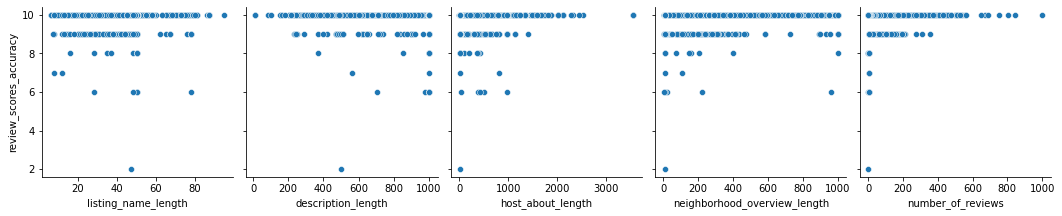

In [21]:
sns.pairplot(listing, 
             x_vars = ['listing_name_length', 'description_length', 'host_about_length', 'neighborhood_overview_length', 'number_of_reviews'], 
             y_vars = ['review_scores_accuracy'], 
             diag_kind = None, 
             height = 3);

look at what amenities have the highest correlations to the high scored reviews 

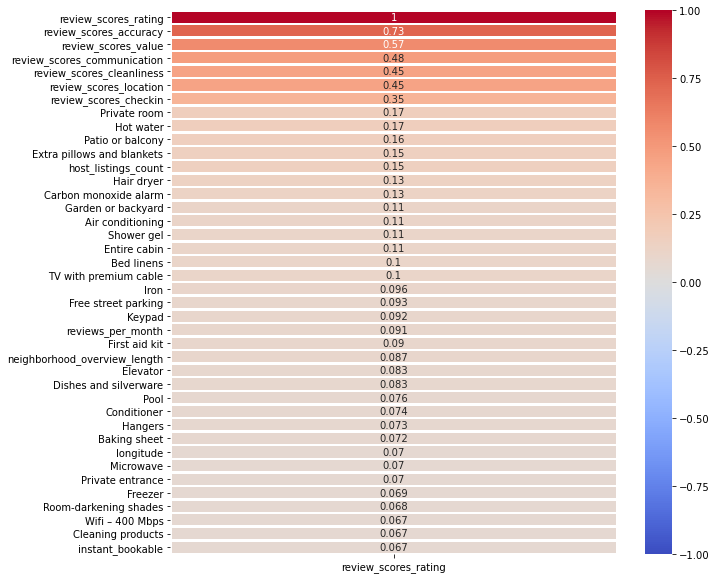

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_rating']].abs().sort_values(by = ['review_scores_rating'], ascending = False)

sns.heatmap(corrs.head(40),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

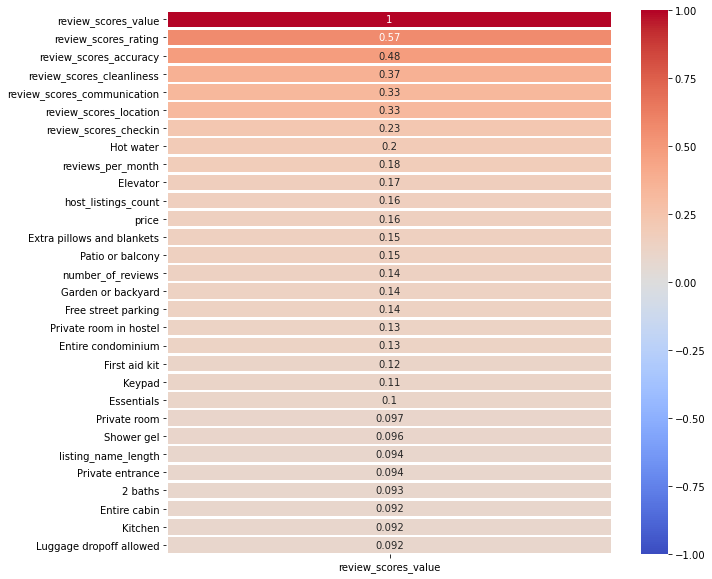

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['review_scores_value']].abs().sort_values(by = ['review_scores_value'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

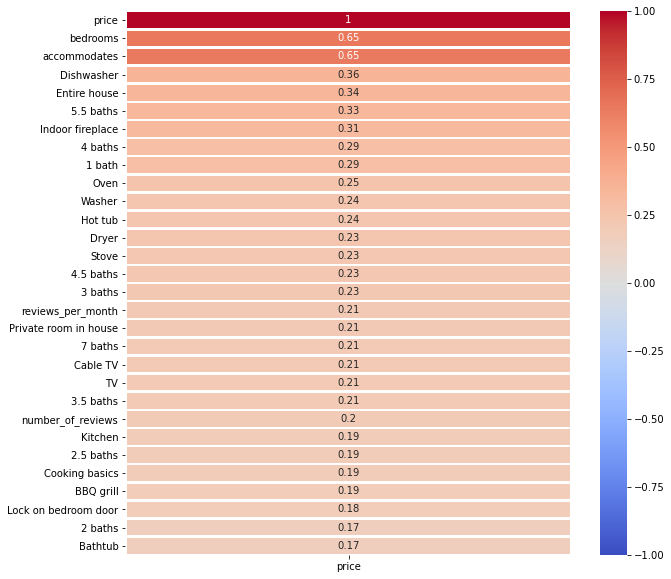

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing.corr()[['price']].abs().sort_values(by = ['price'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

## Sentiment Analysis

In [25]:
pd.options.display.max_colwidth = 200

In [26]:
corpus = list(review['comments']) 

In [27]:
sia = SentimentIntensityAnalyzer()

In [28]:
sentiment = []    

for comment in corpus:
    scores = sia.polarity_scores(comment)
    scores['comment'] = comment
    sentiment.append(scores)

reviews = pd.DataFrame(sentiment)
reviews.head()

,neg,neu,pos,compound,comment
0,0.044,0.830,0.126,0.8732,"Please look at the pictures closely and read the captions. There is not a range stove and oven, just a toaster oven and a small electric two-top stove. The location is nice as it's very close to d..."
1,0.000,0.861,0.139,0.5972,Lisa is an exceptional host and appreciated her knowledge of the local places to check out! Very close walking distance to downtown bars and eateries!
2,0.000,0.638,0.362,0.9766,Lisa's place was the perfect introduction to Asheville living. She was responsive and helped to make me feel right at home. I loved the neighborhood and my dog enjoyed the large yard and windows...
3,0.041,0.877,0.082,0.3182,"A fine place if you need somewhere close to downtown or UNCA. We informed the owner of some issues that we had such as ants, lack of AC during hot months, and some old/dirty rugs and furniture. If..."
4,0.000,0.551,0.449,0.9812,"This is an amazing space in a great location with a wonderful host. Lisa is quick to respond to any questions and very kind and accommodating. The space is very comfortable, quiet and clean. I ..."


In [29]:
reviews['id'] = review['listing_id']

In [30]:
reviews.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
28628,0.0,0.055,0.945,0.9531,Great value. Super Clean. Great location.,19101996
59769,0.0,0.063,0.937,0.9299,"Great hosts, great value. Well recommended!",34207606
11951,0.0,0.067,0.933,0.9186,"Nice place, clean, good value, friendly.",10632884
17976,0.0,0.076,0.924,0.9758,"Great location, comfortable, peaceful, and clean! Super great value!",14649826
48728,0.0,0.080,0.920,0.9098,Super friendly & a great location!,26335600
59516,0.0,0.083,0.917,0.9689,"Kind, comfortable and easy!! Definitely a great value - thx Melissa!",33999981
56983,0.0,0.098,0.902,0.9606,"Amazing place! Super cute, comfortable. Great location.",31493518
16227,0.0,0.101,0.899,0.9812,"Awesome, awesome, awesome! Super clean, great hosts and a fabulous location.",13556933
29865,0.0,0.105,0.895,0.9523,"Excellent value, super clean and great location!",19809125
1552,0.0,0.113,0.887,0.9402,"Clean, well supplied, great amenities, great value!",942934


In [31]:
reviews.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,comment,id
58244,0.570,0.430,0.000,-0.4554,Cannot recommend really. Very sorry.,32739890
51328,0.540,0.460,0.000,-0.5719,I would book it again. No doubt,27853519
16885,0.454,0.546,0.000,-0.7678,Steep but manageable driveway. No complaints! Would stay here again.,13877850
30787,0.453,0.334,0.213,-0.5575,Overall very good; nothing outstandingly great or bad.,20146236
17931,0.442,0.270,0.288,-0.1796,I have no complaints. I was very pleased.,14632829
3091,0.433,0.250,0.317,-0.1007,"Charming place, convenient location, no complaints!",2296152
44719,0.422,0.244,0.334,0.1260,Ben was a great host. No complaints!,24222452
57448,0.422,0.082,0.496,0.2282,Very nice & clean. No problems.,31834926
7121,0.422,0.244,0.334,0.1260,Great place to stay. No complaints!,5333015
17454,0.422,0.259,0.319,-0.0516,Wonderful place to stay. No complaints,14357005


In [32]:
reviews.sort_values(by = 'pos', ascending = True).head(10)

,neg,neu,pos,compound,comment,id
36381,0.000,1.000,0.0,0.0000,It was just what we needed!!,21399365
15310,0.259,0.741,0.0,-0.4215,Convenient to everything Asheville. Yet off the beaten path.,13136198
60194,0.000,1.000,0.0,0.0000,"Quiet location, close to downtown and Blue Ridge Parkway, overall stars!",35038518
38437,0.000,1.000,0.0,0.0000,This place is a must stay for Asheville,22224397
60179,0.000,1.000,0.0,0.0000,Quiet and tasteful about minutes drive to downtown,35033865
38430,0.000,1.000,0.0,0.0000,Live staying at this location! Quiet and convenient!,22224397
38390,0.000,1.000,0.0,0.0000,Very convenient to everything in Asheville. Biltmore was only mile away and downtown was / miles in the other direction.Recommend it highly!,22163415
11859,0.000,1.000,0.0,0.0000,"This place was perfect... quick booking, check in was a breeze, and a cozy space. Very close to downtown!",10632884
38355,0.000,1.000,0.0,0.0000,"Their home had everything I wanted and more. If you're looking to get away for a few days, this is the place to be!",22163415
4962,0.000,1.000,0.0,0.0000,This place had exactly what we needed!,3569949


Aggregating at the ID level taking the mean per column and then merging the dataframes.

In [33]:
reviews_agg = reviews.groupby('id', as_index=False)['pos', 'neu', 'neg', 'compound'].mean()

In [34]:
listing_reviews = listing.merge(reviews_agg, on = 'id')

In [35]:
listing_reviews.shape

(1500, 494)

In [36]:
listing_reviews.isnull().sum().sum()

0

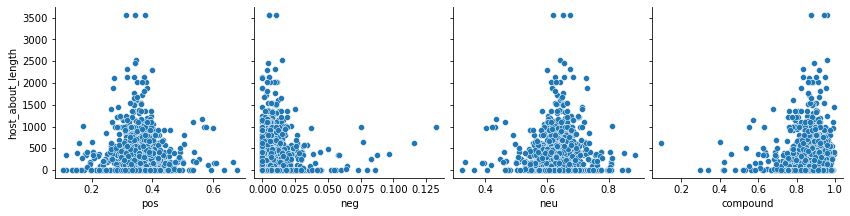

In [37]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['host_about_length'], 
             diag_kind = None, 
             height = 3);

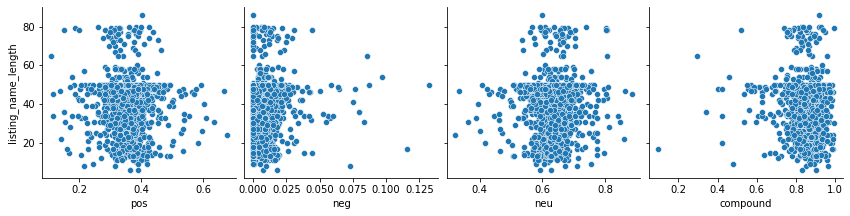

In [38]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['listing_name_length'], 
             diag_kind = None, 
             height = 3);

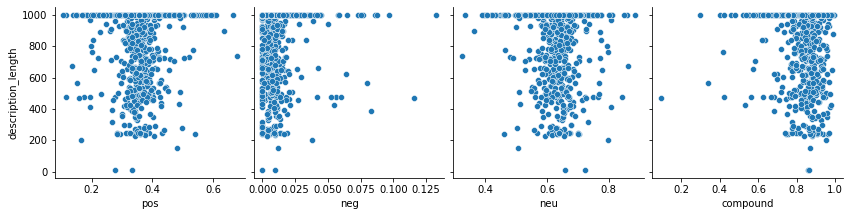

In [39]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['description_length'], 
             diag_kind = None, 
             height = 3);

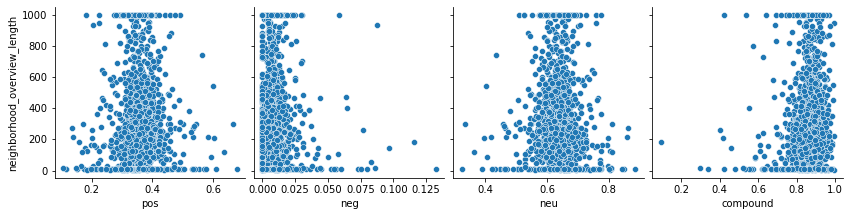

In [40]:
sns.pairplot(listing_reviews, 
             x_vars = ['pos', 'neg', 'neu', 'compound'], 
             y_vars = ['neighborhood_overview_length'], 
             diag_kind = None, 
             height = 3);

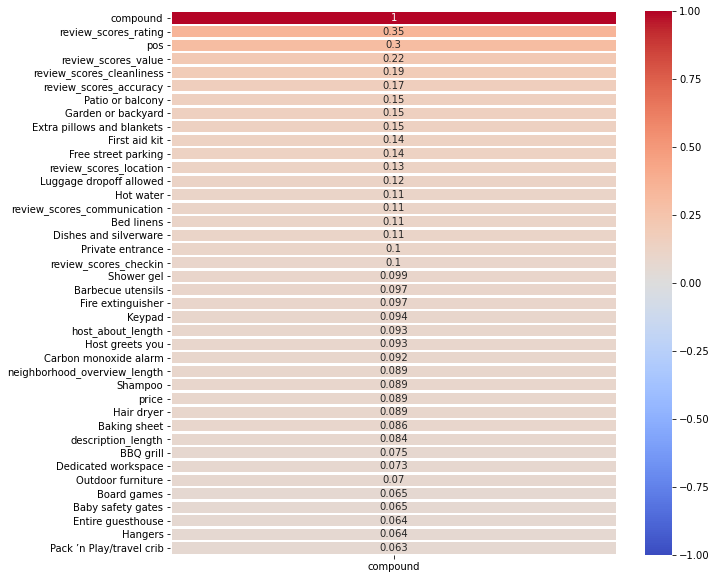

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['compound']].sort_values(by = ['compound'], ascending = False)

sns.heatmap(corrs.head(40),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

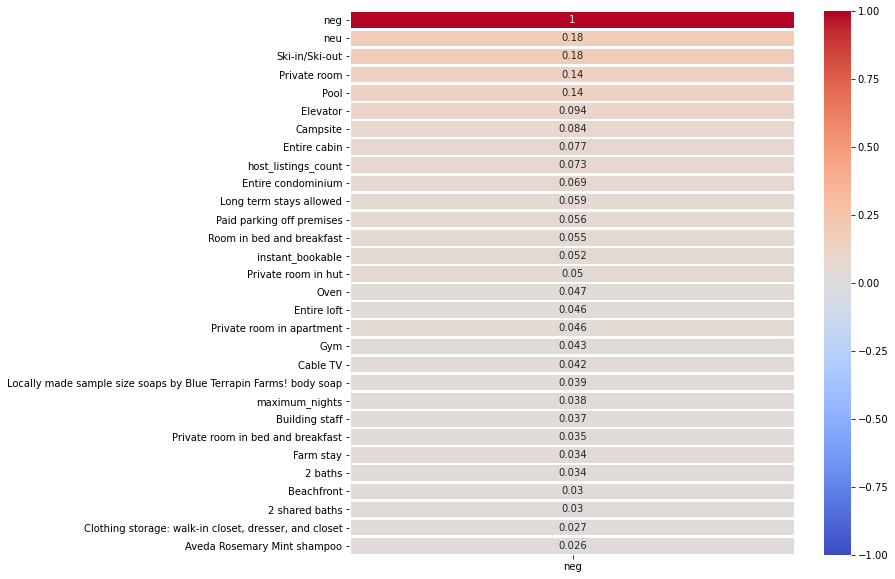

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neg']].sort_values(by = ['neg'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

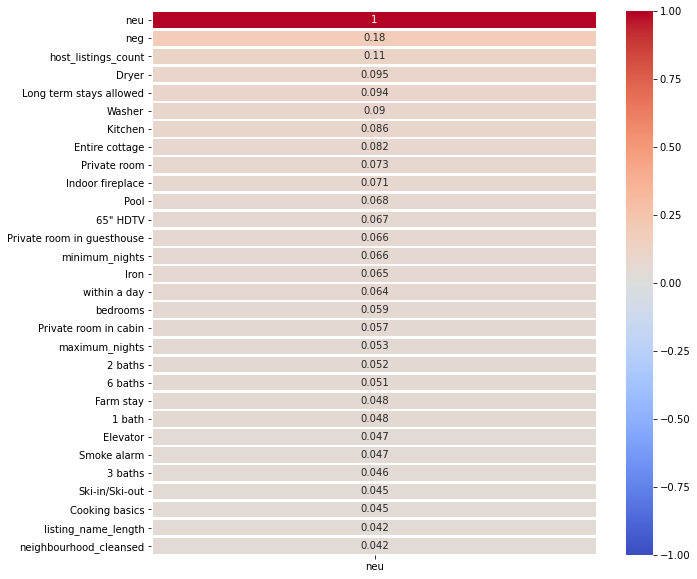

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['neu']].sort_values(by = ['neu'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

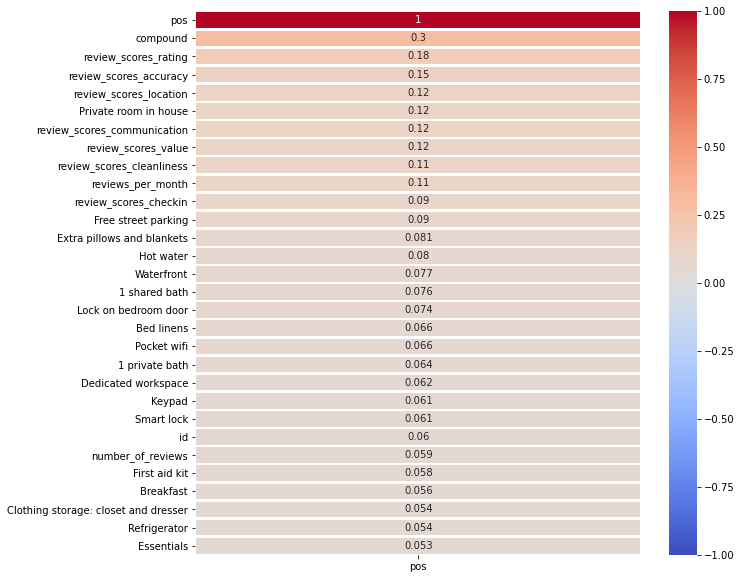

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
corrs = listing_reviews.corr()[['pos']].sort_values(by = ['pos'], ascending = False)

sns.heatmap(corrs.head(30),
            cmap= 'coolwarm',
            annot= True, 
            vmax= 1, 
            vmin= -1, 
            linewidths=1.5, 
            ax=ax);

In [45]:
listing_reviews.sort_values(by = 'pos', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"32"" HDTV","32"" HDTV with Netflix","32"" HDTV with Netflix, Roku, Amazon Prime Video","32"" HDTV with Roku","32"" TV","32"" TV with Netflix, HBO Max","32"" TV with Roku","40"" HDTV","40"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" TV with premium cable","42"" HDTV with Amazon Prime Video, Netflix","43"" HDTV with Roku","43"" TV","45"" TV with Roku","50"" HDTV","50"" HDTV with Amazon Prime Video, Netflix","50"" HDTV with Netflix","50"" HDTV with Netflix, Amazon Prime Video","50"" HDTV with Netflix, Amazon Prime Video, HBO Max","50"" HDTV with Netflix, Amazon Prime Video, HBO Max, Roku","50"" HDTV with Netflix, standard cable","50"" HDTV with Roku",...,Private room in condominium,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in hut,Private room in townhouse,Private room in treehouse,Room in bed and breakfast,Room in boutique hotel,Room in hotel,Shared room in apartment,Shared room in hostel,Shared room in house,Tent,Tiny house,Treehouse,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4.5 baths,5 baths,5.5 baths,6 baths,6.5 baths,7 baths,Half-bath,Private half-bath,a few days or more,within a day,within a few hours,within an hour,pos,neu,neg,compound
651,21798869,Montford Urban Treehouse,"Brand new 650 SF detached garage apartment in charming, historic Montford neighborhood. It is a short walk to several eateries and nightspots, and a 20-min walk to downtown. Inside has vaulted c...",No Content,2017-04-08,No Content,1.00,2,28801,35.60792,-82.57085,3,1.0,95,30,1125,3,2019-04-08,2020-05-31,100.0,9.0,10.0,10.0,10.0,10.0,10.0,1,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6770,0.3230,0.0,0.95780
1128,32496511,#4 - Rocky River Cabin - Asheville River Cabins,"Stone gas fireplace for cool romantic nights, & ceiling fans to cool romantic nights. Central air & heat, queen bed in the bedroom, fold-out sofa in living room. Satellite Direct TV, shower in c...","The cabin's location is unique in that it is located only two miles from Biltmore Park Town Center with restaurants, movie theaters, & shopping. Two miles in the opposite direction, guests will f...",2015-12-29,"Retired College Professor / Real Estate Broker/ Investor / Resort Owner\r\n\r\n""There are two kinds of people, the tolerant and the intolerant, which one lives by the Golden Rule?""",36.50,7,28704,35.49031,-82.57355,4,1.0,219,1,1125,2,2019-04-10,2019-10-22,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6660,0.3340,0.0,0.87450
788,24425345,"Mountain Views, Minutes to Work",Main floor of a two story home. Open floor plan with plenty of light. Two sliding glass doors onto a deck with mountain views (Craggy's Pinnicle). Large bedroom with office space. Kitchen and liv...,"Quiet dead end street, feels like you are out of town. But it’s minutes to get to Biltmore village and to down town.",2016-04-10,No Content,0.50,2,28803,35.56932,-82.52551,2,1.0,62,30,120,4,2018-07-03,2019-01-12,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [46]:
listing_reviews.sort_values(by = 'neg', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"32"" HDTV","32"" HDTV with Netflix","32"" HDTV with Netflix, Roku, Amazon Prime Video","32"" HDTV with Roku","32"" TV","32"" TV with Netflix, HBO Max","32"" TV with Roku","40"" HDTV","40"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" TV with premium cable","42"" HDTV with Amazon Prime Video, Netflix","43"" HDTV with Roku","43"" TV","45"" TV with Roku","50"" HDTV","50"" HDTV with Amazon Prime Video, Netflix","50"" HDTV with Netflix","50"" HDTV with Netflix, Amazon Prime Video","50"" HDTV with Netflix, Amazon Prime Video, HBO Max","50"" HDTV with Netflix, Amazon Prime Video, HBO Max, Roku","50"" HDTV with Netflix, standard cable","50"" HDTV with Roku",...,Private room in condominium,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in hut,Private room in townhouse,Private room in treehouse,Room in bed and breakfast,Room in boutique hotel,Room in hotel,Shared room in apartment,Shared room in hostel,Shared room in house,Tent,Tiny house,Treehouse,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4.5 baths,5 baths,5.5 baths,6 baths,6.5 baths,7 baths,Half-bath,Private half-bath,a few days or more,within a day,within a few hours,within an hour,pos,neu,neg,compound
1132,32560585,"Updated Home - Near Area Breweries, Shops & Dining","Located between Asheville and Hendersonville, this updated 3BR home is close to local shopping and dining -- and must-see attractions like Lake Lure, Chimney Rock, and the Biltmore Estate. Enjoy a...",No Content,2017-09-07,"From all of us at TurnKey Vacation Rentals, we can’t wait to help you plan your perfect stay! We’re a bunch of passionate travel professionals creating extraordinary experiences for you … Every Ho...",0.99,116,28732,35.43812,-82.46448,8,3.0,150,2,1125,4,2019-05-27,2020-11-24,95.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.278500,0.5890,0.1325,0.550500
1411,38573541,Bear-a-dise Found,Absolutely adorable and totally remodeled apartment overlooking the pool area of the Bear Creek RV park & Campground. This place is fairly private and perfect for two people or a family with child...,"We are located just miles from the Biltmore Estate, breweries, local restaurants, Blue Ridge Parkway, Farmers Market and the Outlet Mall. Easy 7-10 minute drive to Downtown Asheville.",2016-05-13,"Hello! I am a Cross fit Chick, I Love to travel to Key West ( and many other places), I have 2 AWESOME teenage daughters, and I work with my handsome hubby of nearly 21 years. I am not originall...",0.99,8,28806,35.55662,-82.60591,2,1.0,145,3,1125,6,2019-10-08,2021-02-14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.158500,0.7260,0.1155,0.095100
428,16868257,Taylor Ranch Retreat - Secluded yet close to Asheville,"This cozy private home, nestled in the trees, is centrally located between Asheville and Hendersonville, North Carolina. It is down a dirt road and is very secluded for your privacy and full feel ...","The property is located next to a working 400 acre ranch, while hiking the ranch is not permitted, it provides a very private, country experience.",2017-01-20,"I am 

In [47]:
listing_reviews.sort_values(by = 'compound', ascending = False).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"32"" HDTV","32"" HDTV with Netflix","32"" HDTV with Netflix, Roku, Amazon Prime Video","32"" HDTV with Roku","32"" TV","32"" TV with Netflix, HBO Max","32"" TV with Roku","40"" HDTV","40"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" TV with premium cable","42"" HDTV with Amazon Prime Video, Netflix","43"" HDTV with Roku","43"" TV","45"" TV with Roku","50"" HDTV","50"" HDTV with Amazon Prime Video, Netflix","50"" HDTV with Netflix","50"" HDTV with Netflix, Amazon Prime Video","50"" HDTV with Netflix, Amazon Prime Video, HBO Max","50"" HDTV with Netflix, Amazon Prime Video, HBO Max, Roku","50"" HDTV with Netflix, standard cable","50"" HDTV with Roku",...,Private room in condominium,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in hut,Private room in townhouse,Private room in treehouse,Room in bed and breakfast,Room in boutique hotel,Room in hotel,Shared room in apartment,Shared room in hostel,Shared room in house,Tent,Tiny house,Treehouse,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4.5 baths,5 baths,5.5 baths,6 baths,6.5 baths,7 baths,Half-bath,Private half-bath,a few days or more,within a day,within a few hours,within an hour,pos,neu,neg,compound
1178,33398534,"Wentworth Hilltop: Private home, outside Biltmore Village + close to Asheville!","Wentworth Hilltop: Stunning new ""green"" construction with surprising views, high-end finishes, and mere minutes to downtown & everything Asheville! Your must-stay Asheville destination! Wow, spect...",WNC,2016-09-21,Yonder Luxury Vacation Rentals has designed the vacation experience around each Yonder Home to invigorate and inspire. Every Yonder Home is individually decorated and beautifully furnished for you...,0.99,145,28803,35.55252,-82.50787,8,3.0,229,2,365,9,2019-05-12,2020-11-25,98.0,10.0,10.0,10.0,9.0,10.0,9.0,1,0.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.1860,0.804,0.011,0.99370
851,26280621,"Convenience, Charm and Comfort","You'll love my spacious and airy apartment nestled in the historic tree lined Montford District. Delight in eclectic sun filled rooms with old world charm. This one bedroom, fully outfitted, month...","Your new home is perfectly situated in ""Montford"", a historic tree lined district which is one of the most desirable neighborhoods to live and stay in.Just a half mile from downtown, this is a mat...",2013-12-11,"I'm a fairly eclectic and diversified individual who has several interests which span many disciplines including history, travel, Civic altruism, and the Arts. I spent many years in the service in...",0.96,3,28801,35.60776,-82.56582,2,1.0,96,30,60,2,2019-10-20,2019-11-03,100.0,10.0,9.0,10.0,10.0,10.0,9.0,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.2250,0.758,0.017,0.99150
29,977054,The Cottage In Asheville,"COVID-19 UPDATE: Due to safety and logistics issues created by the COVID-19 pandemic, the cottage is not available for booking. Please check back often for updates. <br /><br />Corporate/temporary...","We are one block away from the Glenn's Creek Greenway, 1/2 mile from the Botanical Gardens of UNC-A, 1 mile from excellent grocery shopping including a Whole

In [48]:
listing_reviews.sort_values(by = 'compound', ascending = True).head(10)

,id,name,description,neighborhood_overview,host_since,host_about,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,accommodates,bedrooms,price,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,"32"" HDTV","32"" HDTV with Netflix","32"" HDTV with Netflix, Roku, Amazon Prime Video","32"" HDTV with Roku","32"" TV","32"" TV with Netflix, HBO Max","32"" TV with Roku","40"" HDTV","40"" HDTV with Netflix, Amazon Prime Video, Chromecast","40"" TV with premium cable","42"" HDTV with Amazon Prime Video, Netflix","43"" HDTV with Roku","43"" TV","45"" TV with Roku","50"" HDTV","50"" HDTV with Amazon Prime Video, Netflix","50"" HDTV with Netflix","50"" HDTV with Netflix, Amazon Prime Video","50"" HDTV with Netflix, Amazon Prime Video, HBO Max","50"" HDTV with Netflix, Amazon Prime Video, HBO Max, Roku","50"" HDTV with Netflix, standard cable","50"" HDTV with Roku",...,Private room in condominium,Private room in cottage,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in hut,Private room in townhouse,Private room in treehouse,Room in bed and breakfast,Room in boutique hotel,Room in hotel,Shared room in apartment,Shared room in hostel,Shared room in house,Tent,Tiny house,Treehouse,Yurt,0 baths,0 shared baths,1 bath,1 private bath,1 shared bath,1.5 baths,1.5 shared baths,2 baths,2 shared baths,2.5 baths,2.5 shared baths,3 baths,3.5 baths,4 baths,4.5 baths,5 baths,5.5 baths,6 baths,6.5 baths,7 baths,Half-bath,Private half-bath,a few days or more,within a day,within a few hours,within an hour,pos,neu,neg,compound
1411,38573541,Bear-a-dise Found,Absolutely adorable and totally remodeled apartment overlooking the pool area of the Bear Creek RV park & Campground. This place is fairly private and perfect for two people or a family with child...,"We are located just miles from the Biltmore Estate, breweries, local restaurants, Blue Ridge Parkway, Farmers Market and the Outlet Mall. Easy 7-10 minute drive to Downtown Asheville.",2016-05-13,"Hello! I am a Cross fit Chick, I Love to travel to Key West ( and many other places), I have 2 AWESOME teenage daughters, and I work with my handsome hubby of nearly 21 years. I am not originall...",0.99,8,28806,35.55662,-82.60591,2,1.0,145,3,1125,6,2019-10-08,2021-02-14,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.1585,0.7260,0.115500,0.095100
1422,38710999,Newly renovated charming condo in Historic King James Building #6,"Charming and newly renovated 1 bedroom/1 bathroom condo on the 3rd level of the historic King James Building. With incredible views of downtown Asheville and the Blue Ridge Mountains, you can also...",North Asheville,2018-01-11,No Content,1.00,60,28801,35.60304,-82.54608,4,1.0,174,1,365,24,2019-09-22,2020-12-29,93.0,9.0,10.0,10.0,10.0,10.0,9.0,1,1.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.1070,0.8070,0.086000,0.296000
821,25281090,Very Special Downtown Asheville Loft,"Come stay in this very special loft, located in historic downtown Asheville, a romantic and unique city surrounded by the beauty of Western North Carolina's mountains.<br /><br />Our loft is on th...",No Content,2015-05-19,No Content,36.50,1,28801,35.59575,-82.55438,2,1.0,240,3,1125,4,2019-03-10,2020-11-08,100.0,10.0,10.0,9.0,10.0,10.0,10.0,1,0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.1510,0.7690,0.080000,0.340000
84,3522134,West Asheville 3 BR/2BA with

## Pre-Processing

Splitting up the dataframe into 3 separate dataframes in order to be able to see what words are popping up in negative reviews, positive reviews, and neutral reviews.

In [49]:
reviews_neu = reviews[(reviews['neu'] == 1.000) | (reviews['neg'] == reviews['pos'])]
reviews_pos = reviews[reviews['pos'] > reviews['neg']]
reviews_neg = reviews[reviews['neg'] > reviews['pos']]


print(f'Neutral Reviews: {reviews_neu.shape}')
print(f'Positive Reviews: {reviews_pos.shape}')
print(f'Negative Reviews: {reviews_neg.shape}')

Neutral Reviews: (514, 6)
Positive Reviews: (62209, 6)
Negative Reviews: (350, 6)


Adding stop words that proved to be frequent words but showed no value.

In [50]:
words = ['asheville', 'didn', 'definitely', 'check', 'bnb', 'air', 've', 'did', 'needed', 'was', 'wa', 'airbnb', 
         'enjoyed', 'beautiful', 'nice', 'touch','minute', 'place', 'stay', 'great', 'space', 'apartment', 'super', 
         'private', 'bit','home']

stop_words = text.ENGLISH_STOP_WORDS.union(words)

In [51]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000)

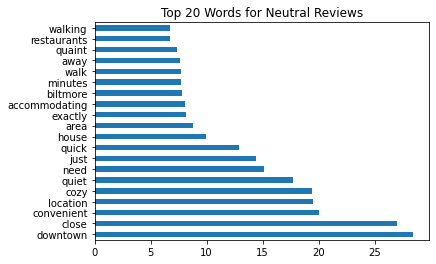

In [52]:
X_tvec_neu = tvec.fit_transform(reviews_neu['comment'])

df_X_neu = pd.DataFrame(X_tvec_neu.todense(), columns = tvec.get_feature_names())

df_X_neu.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Neutral Reviews');

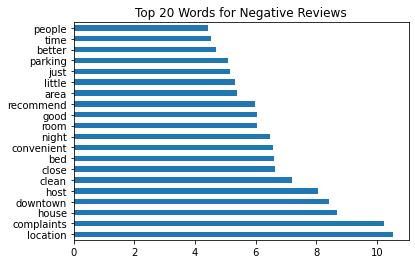

In [53]:
X_tvec_neg = tvec.fit_transform(reviews_neg['comment'])

df_X_neg = pd.DataFrame(X_tvec_neg.todense(), columns = tvec.get_feature_names())

df_X_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Negative Reviews');

In [54]:
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 4000, min_df = 0.001)

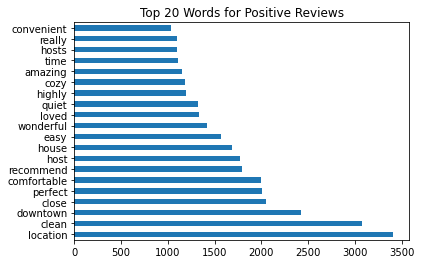

In [55]:
X_tvec_pos = tvec.fit_transform(reviews_pos['comment'])

df_X_pos = pd.DataFrame(X_tvec_pos.todense(), columns = tvec.get_feature_names())

df_X_pos.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Words for Positive Reviews');

#### Bigrams

In [56]:
tvec_2 = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2))

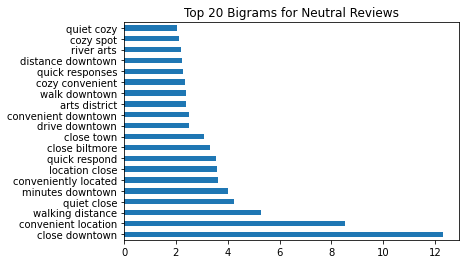

In [57]:
X_2_tvec_neu = tvec_2.fit_transform(reviews_neu['comment'])

df_X_2_neu = pd.DataFrame(X_2_tvec_neu.todense(), columns = tvec_2.get_feature_names())

df_X_2_neu.sum().sort_values(ascending = False).head(20).plot(kind='barh')
plt.title('Top 20 Bigrams for Neutral Reviews');

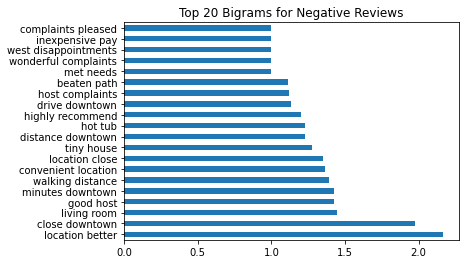

In [58]:
X_2_tvec_neg = tvec_2.fit_transform(reviews_neg['comment'])

df_X_2_neg = pd.DataFrame(X_2_tvec_neg.todense(), columns = tvec_2.get_feature_names())

df_X_2_neg.sum().sort_values(ascending = False).head(20).plot(kind ='barh')
plt.title('Top 20 Bigrams for Negative Reviews');

In [59]:
tvec_2_pos = TfidfVectorizer(stop_words = stop_words, ngram_range = (2,2), min_df = 0.001)

In [60]:
X_2_tvec_pos = tvec_2_pos.fit_transform(reviews_pos['comment'])

In [61]:
df_X_2_pos = pd.DataFrame(X_2_tvec_pos.todense(), columns = tvec_2_pos.get_feature_names())

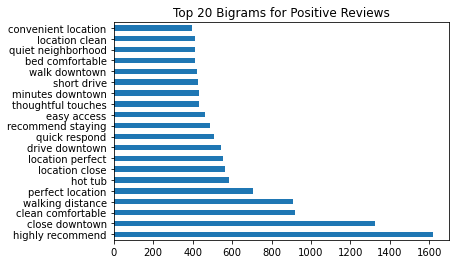

In [62]:
df_X_2_pos.sum().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Top 20 Bigrams for Positive Reviews');

Creating a df for all rows tvec

In [63]:
tvec_reviews = tvec.fit_transform(reviews['comment'])

tvec_reviews_df = pd.DataFrame(tvec_reviews.todense(), columns = tvec.get_feature_names())

Adding back the 'id'column

In [64]:
tvec_reviews_df['id'] = review['listing_id']

In [65]:
tvec_reviews_df = tvec_reviews_df.groupby('id', as_index=False).mean()

In [66]:
listing_tvec_reviews = listing.merge(tvec_reviews_df, on = 'id')

In [67]:
listing_tvec_reviews.shape

(1500, 2110)

## Pre-Processing

the lemmatized text will be vectorized using a TF-IDF vectorizer and converted to a term document matrix that is compatible with the Gensim NLP library.



In [69]:
# Tokenization: 
#     Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

reviews['review_tokens'] = reviews.apply(lambda row: word_tokenize(row['comment']), axis = 1)

In [70]:
# Words are lemmatized:
#     words in third person are changed to first person and verbs in past and future tenses are changed into present.
# Lemmatizing and stemming are two forms of shortening words so we can combine similar forms of the same word.
# When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word.

def lemmatize_text(review):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in review]

reviews['review_lemmatized'] = reviews['review_tokens'].apply(lemmatize_text)
reviews['review_lemmatized'] = reviews['review_lemmatized'].str.join(' ')

In [71]:
tvec = TfidfVectorizer(stop_words = stop_words, min_df = 0.001, ngram_range = (1,2))

tvec_reviews = tvec.fit_transform(reviews['review_lemmatized'])    #Sparce Matrix

In [72]:
tvec_t = tvec_reviews.transpose() # transpose document-term matrix -> to convert it to a term-document matrix

# # Convert to Gensim Corpus
# #     Gensim requires the format of the input to be a Gensim corpus data type

sparse = scipy.sparse.csr_matrix(tvec_t)

corpus = matutils.Sparse2Corpus(tvec_t)

In [73]:
dictionary = dict((v,k) for k,v in tvec.vocabulary_.items())

gensim_dict = Dictionary.from_corpus(corpus = corpus, id2word = dictionary)

## Topic Modeling

In [74]:
lda = LdaModel(corpus = corpus, 
               num_topics = 5, 
               id2word = dictionary, 
               passes = 60, 
               decay = 0.8,           
               offset = 10,           
               random_state = 49)

In [75]:
coherence = CoherenceModel(model = lda,
                           corpus = corpus,
                           dictionary = dictionary,
                           coherence = 'u_mass')       

print(round(coherence.get_coherence(), 3))

-2.458


In [76]:
prep = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)

pyLDAvis.display(prep)

Recommendations based off information below...
0. Location is very important. In many positive reviews mentioning the location of the Airbnb, the guests are mentioning "easy" "walk" "restaurant" "downtown" and "walking distance". So for those Airbnb's that are not in the city center, it is key to mention what is walkable from your property so the guest is aware that they have that option.

1. In posts mentioning the property itself, the bathroom and the kitchen are very frequently mentioned 

In [77]:
lda.print_topics(num_topics = 10, num_words = 12)

[(0,
  '0.038*"location" + 0.035*"clean" + 0.015*"recommend" + 0.015*"host" + 0.013*"good" + 0.013*"comfortable" + 0.013*"easy" + 0.011*"convenient" + 0.011*"cute" + 0.010*"exactly" + 0.010*"value" + 0.010*"location clean"'),
 (1,
  '0.018*"walk" + 0.018*"downtown" + 0.017*"walking" + 0.017*"distance" + 0.016*"restaurant" + 0.015*"walking distance" + 0.013*"location" + 0.012*"west" + 0.010*"brewery" + 0.010*"quiet" + 0.010*"neighborhood" + 0.010*"easy"'),
 (2,
  '0.025*"close" + 0.025*"downtown" + 0.021*"perfect" + 0.014*"close downtown" + 0.014*"weekend" + 0.012*"getaway" + 0.011*"biltmore" + 0.011*"location" + 0.010*"drive" + 0.010*"away" + 0.010*"spot" + 0.009*"clean"'),
 (3,
  '0.007*"bed" + 0.007*"house" + 0.006*"like" + 0.006*"comfortable" + 0.006*"room" + 0.005*"loved" + 0.005*"coffee" + 0.005*"clean" + 0.004*"little" + 0.004*"kitchen" + 0.004*"time" + 0.004*"area"'),
 (4,
  '0.023*"host" + 0.011*"wonderful" + 0.011*"amazing" + 0.010*"helpful" + 0.010*"recommend" + 0.010*"time" 